Universidad del Valle de Guatemala <br>
Deep Learning <br>
Sec. 20 <br>
Proyecto Final <br>

Integrantes: <br>
Javier Chávez 21016 <br>
Mario Cristales 21631 <br>
Andres Quezada 21085 <br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import re


file_path = '/content/drive/My Drive/ColabData/blackjack.csv'
data = pd.read_csv(file_path, nrows=500000)

data.head()


Mounted at /content/drive


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


In [2]:
import numpy as np
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Selection of relevant columns
data = data[['cards_remaining', 'dealer_up', 'initial_hand', 'run_count', 'true_count', 'actions_taken', 'win']]

# 2. Card transformation
def card_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11  # Assume Ace is 11 initially
    else:
        return int(card)

data['dealer_up'] = data['dealer_up'].apply(lambda x: card_value(str(x)))
data['initial_hand'] = data['initial_hand'].apply(lambda x: [card_value(card) for card in eval(x)])
data['initial_card_1'] = data['initial_hand'].apply(lambda x: x[0] if len(x) > 0 else 0)
data['initial_card_2'] = data['initial_hand'].apply(lambda x: x[1] if len(x) > 1 else 0)

# Calculate player's initial hand value
def calculate_hand_value(hand):
    value = sum(hand)
    aces = hand.count(11)
    while value > 21 and aces:
        value -= 10  # Convert an Ace from 11 to 1
        aces -= 1
    return value

data['player_hand_value'] = data['initial_hand'].apply(calculate_hand_value)

# Drop 'initial_hand' as we have extracted necessary information
data.drop(columns=['initial_hand'], inplace=True)

# 3. Action changes counter
action_changes = {
    'Hits changed to Stand': 0,
    'Stands changed to Hit': 0,
    'Doubles changed to Stand': 0,
    'Stands changed to Double': 0,
}

# 4. Function to extract the first action using regex
def extract_first_action(actions):
    actions_str = str(actions)
    match = re.search(r"[A-Z]+", actions_str)  # Find the first action
    return match.group(0) if match else None

# Apply extraction of the first action
data['actions_taken'] = data['actions_taken'].apply(extract_first_action)

# Remove rows with None values in 'actions_taken'
data = data.dropna(subset=['actions_taken'])

# 5. Select 50% of losing hands to modify
losses_mask = data['win'] < 0
loss_indices = data[losses_mask].index
half_loss_indices = np.random.choice(loss_indices, size=len(loss_indices) // 2, replace=False)

# 6. Function to modify actions in losing hands
def modify_action(action):
    if action == 'H':
        action_changes['Hits changed to Stand'] += 1
        return 'S'
    elif action == 'S':
        action_changes['Stands changed to Hit'] += 1
        return 'H'
    elif action == 'D':
        action_changes['Doubles changed to Stand'] += 1
        return 'S'
    elif action == 'S':
        action_changes['Stands changed to Double'] += 1
        return 'D'
    return action

# Apply changes only to the selected 50% of losing hands
data.loc[half_loss_indices, 'actions_taken'] = data.loc[half_loss_indices, 'actions_taken'].apply(modify_action)

# Encode 'actions_taken' after extraction and modification
encoder = LabelEncoder()
data['actions_taken'] = encoder.fit_transform(data['actions_taken'])

# Normalize numerical features
scaler = StandardScaler()
data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.fit_transform(
    data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
)

# Drop auxiliary columns
data.drop(columns=['win'], inplace=True)

# Display action changes count
print("\nAction changes count:")
for change, count in action_changes.items():
    print(f"{change}: {count}")

# Display action mapping
print("\nAction mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# Display head of the dataframe
data.head()



Action changes count:
Hits changed to Stand: 45700
Stands changed to Hit: 36726
Doubles changed to Stand: 9405
Stands changed to Double: 0

Action mapping: {'D': 0, 'H': 1, 'N': 2, 'P': 3, 'R': 4, 'S': 5}


,cards_remaining,dealer_up,run_count,true_count,actions_taken,initial_card_1,initial_card_2,player_hand_value
0,1.702052,10,0.104190,-0.019092,5,10,11,1.574949
1,1.651173,10,-0.275107,-0.019092,1,5,5,-1.115650
2,1.600293,6,-0.275107,-0.019092,5,3,10,-0.381850
3,1.549414,10,-0.148675,-0.019092,1,5,9,-0.137250
4,1.488358,8,-0.148675,-0.019092,5,6,10,0.351949


In [3]:
# Imprimir el mapeo de clases para 'actions_taken'
action_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapping de acciones:", action_mapping)


Mapping de acciones: {'D': 0, 'H': 1, 'N': 2, 'P': 3, 'R': 4, 'S': 5}


In [6]:
# Separate features (X) and labels (y)
X = data[['cards_remaining', 'dealer_up', 'initial_card_1', 'initial_card_2', 'run_count', 'true_count', 'player_hand_value']].values
y = data['actions_taken'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the MLP model
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')  # Usamos softmax para salida de clasificación
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12207/12207 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.7252 - loss: 0.6513 - val_accuracy: 0.7999 - val_loss: 0.4483
Epoch 2/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.7998 - loss: 0.4450 - val_accuracy: 0.8074 - val_loss: 0.4302
Epoch 3/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.8071 - loss: 0.4301 - val_accuracy: 0.8093 - val_loss: 0.4224
Epoch 4/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.8083 - loss: 0.4261 - val_accuracy: 0.8091 - val_loss: 0.4232
Epoch 5/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8078 - loss: 0.4259 - val_accuracy: 0.8108 - val_loss: 0.4217
Epoch 6/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.8088 - loss: 0.4233 - val_accuracy: 0.8097 - val_loss: 0.4218
Epoch 7/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8097 - loss: 0.4230 - val_accuracy: 0.8011 - val_loss: 0.4359
Epoch 8/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.8121 - lo

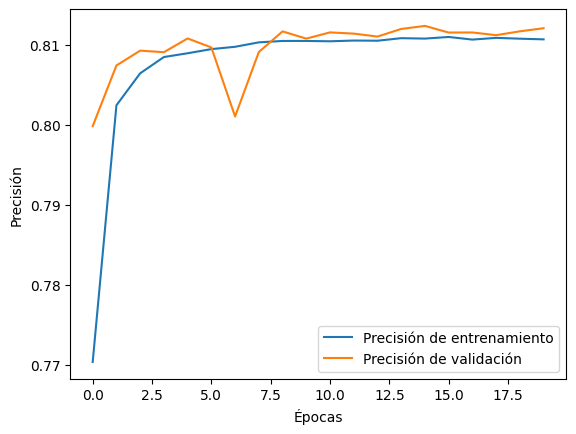

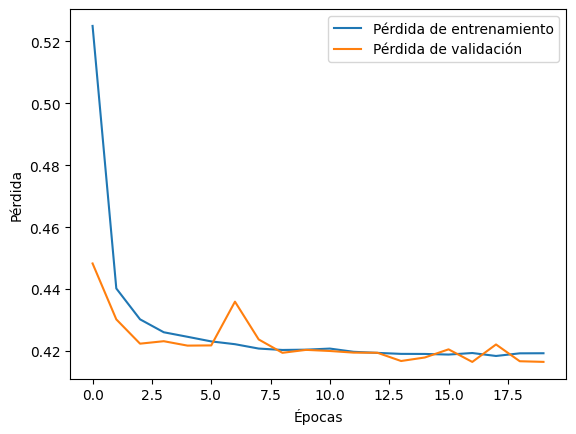

In [7]:
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [8]:
# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}')


3052/3052 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8109 - loss: 0.4184
Precisión en el conjunto de prueba: 0.81


In [9]:
import numpy as np
import random
import pandas as pd

# Values of the cards
card_values_dict = {
    '2': 2, '3': 3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
    'J':10, 'Q':10, 'K':10, 'A':11  # Ace can be 11 or 1; we'll handle this later
}

# Function to create a deck of cards
def create_deck(num_decks=6):
    deck = []
    for _ in range(num_decks):  # Using multiple decks
        for card in card_values_dict.keys():
            deck.extend([card]*4)
    random.shuffle(deck)
    return deck

# Function to calculate the value of a hand
def calculate_hand_value(hand):
    value = 0
    aces = 0
    for card in hand:
        card_value = card_values_dict[card]
        value += card_value
        if card == 'A':
            aces += 1
    # Adjust for Aces
    while value > 21 and aces:
        value -= 10
        aces -= 1
    return value

# Function to deal a card
def deal_card(deck):
    if len(deck) == 0:
        # If the deck is empty, reshuffle
        deck.extend(create_deck())
    return deck.pop()

# Function to check if a hand busts
def is_bust(hand):
    return calculate_hand_value(hand) > 21

# Dealer's play according to standard rules
def dealer_play(deck, dealer_hand):
    while calculate_hand_value(dealer_hand) < 17:
        dealer_hand.append(deal_card(deck))
    return dealer_hand

# Function to convert cards to numerical values for the model
def card_to_model_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11
    else:
        return int(card)

# Function to simulate a game
def simulate_game(model, scaler, encoder, deck, run_count, true_count, num_decks=6):
    # Reshuffle deck if necessary
    if len(deck) < (num_decks * 52) * 0.25:
        deck.clear()
        deck.extend(create_deck(num_decks))
        run_count = 0  # Reset count
        random.shuffle(deck)

    # Initial hands
    player_hand = [deal_card(deck), deal_card(deck)]
    dealer_hand = [deal_card(deck), deal_card(deck)]

    # Player's turn
    player_turn = True
    player_actions = []
    while player_turn:
        # Update features for the model
        cards_remaining = len(deck)
        dealer_up_card = card_to_model_value(dealer_hand[0])  # Dealer's visible card
        initial_card_1 = card_to_model_value(player_hand[0])
        initial_card_2 = card_to_model_value(player_hand[1]) if len(player_hand) > 1 else 0
        run_count = 0  # Implement count if desired
        true_count = 0  # Same as above
        player_hand_value = calculate_hand_value(player_hand)

        # Create a DataFrame for features with appropriate column names
        features = pd.DataFrame({
            'cards_remaining': [cards_remaining],
            'dealer_up': [dealer_up_card],
            'initial_card_1': [initial_card_1],
            'initial_card_2': [initial_card_2],
            'run_count': [run_count],
            'true_count': [true_count],
            'player_hand_value': [player_hand_value]
        })

        # Ensure columns are in the same order as during training
        feature_columns = ['cards_remaining', 'dealer_up', 'initial_card_1', 'initial_card_2',
                           'run_count', 'true_count', 'player_hand_value']

        # Normalize the corresponding features
        features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.transform(
            features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
        )

        # Convert features to NumPy array if necessary
        features_array = features[feature_columns].values

        # Predict action
        prediction = model.predict(features_array)
        predicted_action = np.argmax(prediction, axis=1)
        action = encoder.inverse_transform(predicted_action)[0]

        player_actions.append(action)

        if action == 'H':
            # Hit: Deal a card
            player_hand.append(deal_card(deck))
            # Check if player busts
            if is_bust(player_hand):
                player_turn = False
        elif action == 'S':
            # Stand: End player's turn
            player_turn = False
        elif action == 'D':
            # Double: Player doubles bet, receives one card, and stands
            player_hand.append(deal_card(deck))
            # Check if player busts
            if is_bust(player_hand):
                pass  # Player loses
            player_turn = False
        else:
            # Any other action is treated as Stand
            player_turn = False

    # Check if player busts
    if is_bust(player_hand):
        return 'loss', player_actions, player_hand, dealer_hand, deck, run_count, true_count

    # Dealer's turn
    dealer_hand = dealer_play(deck, dealer_hand)

    # Determine result
    player_value = calculate_hand_value(player_hand)
    dealer_value = calculate_hand_value(dealer_hand)

    if is_bust(dealer_hand):
        result = 'win'
    elif player_value > dealer_value:
        result = 'win'
    elif player_value < dealer_value:
        result = 'loss'
    else:
        result = 'draw'

    return result, player_actions, player_hand, dealer_hand, deck, run_count, true_count



In [10]:
# Initialize deck, run_count, and true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0  # Implement count if desired
true_count = 0

# Simulate multiple games
num_games = 1000
results = {'win': 0, 'loss': 0, 'draw': 0}
action_counts = []

for _ in range(num_games):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] += 1
    action_counts.append(len(player_actions))

# Calculate action statistics
total_actions = sum(action_counts)
average_actions_per_game = total_actions / num_games
max_actions = max(action_counts)
min_actions = min(action_counts)

# Display results
print(f"Out of {num_games} games:")
print(f"Wins: {results['win']}")
print(f"Losses: {results['loss']}")
print(f"Draws: {results['draw']}")
print(f"Win rate: {results['win']/num_games * 100:.2f}%")
print(f"Total actions: {total_actions}")
print(f"Average actions per game: {average_actions_per_game:.2f}")
print(f"Max actions in a game: {max_actions}")
print(f"Min actions in a game: {min_actions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━